# Overview

Functionality implemented so far:
1. Read excel files and plot raw traces of graphs `plot_traces`
2. Find & calculate responding cells & plot average number of responding cells per slide for each cell type `percentage_response`, also combine data from all responding cells from all slides for each cell type
3. Graph max utp response for each slide `max_amp_plot`
4. Statistical significance: p-value and effect size `stats.ttest_ind` and `cohen_d`
5. Plot average values for control groups vs. L89A overexpressed groups `average_plot`

TODO's:
** Please open an issue for anything that should be implemented! **

# Code

## Imports

In [1]:
# Import modules for working with excel sheets and for plotting

# matplotlib: module for plotting
# pandas: module for working with dataframe (can be imported from excel, csv, txt)
# %: ipython magic, to plot graphs in line
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import re
from scipy import stats
%matplotlib inline

In [2]:
# `PLOT' is a global variable that needs to be set to `True' to actually plot things in this notebook
PLOT = True

## Load Data

The following dataset is NOT on GitHub. Make sure your local directory structure is as follows:

                    repository_directory
                     /        \        \
                    /          \        \
                  code        assets    other files (.gitignore, README.md, LICENSE.txt, ...)
                   /            \
                  /              \
    <jupyter_notebook_file>    <data_file>
    
Also, if you want to use the functions in this script with another dataset, make sure to change `number_of_rows` 
and the file name in the following import statements.

In [3]:
# Import excel file as a `pandas.ExcelFile' object (which basically has all sub-sheets in a big container!)
# also, only import 1302 rows
number_of_rows = 2100
ca_data = pd.ExcelFile('../assets/2018-09-25 stable MB231 CTRL E120Q 3 uM UTP Ca2+ free.xlsx', nrows=number_of_rows)

## Functions

The following functions are used throughout this notebook to analyze and visualize data.
The doc-string should provide enough information on how they work. 
They basically encapsulate commonly used commands to make re-use easier!

In [4]:
# plot every single trace after reading subsheets and alphabetically sorting them
def plot_traces(df, plot=True):
    """
    this function takes a pandas.io.excel.ExcelFile object and iterates over all sheets
    every column of every such sheet is interpreted as a 'trace' and plotted in a line plot
    a new line plot is created for every sheet in the pandas.io.excel.ExcelFile object
    
    -------------------------a-----
    arguments:
    df        - input data (pandas.io.excel.ExcelFile)
    plot      - defaults to False, if True, plot line plots for every sheet in `df'
    """
    sheetnames = df.sheet_names.copy()
    sheetnames.sort()
    for sheetname in sheetnames: 
        temp = pd.read_excel(df, sheetname)
        if plot:
            temp.plot(title=sheetname, legend=False)

In [5]:
# Find percentage of responding cells per slide and create a new dataframe for values that pass threshold
# Find average according to grouping
def percentage_response(df, threshold=1.2, utp_range=(40,480)):
    """
    this function calculates the response rate for calcium imaging data sets
    it takes a pandas.io.excel.ExcelFile and iterates over all data sheets and 
    columns in the input data frames to find the max value within the UTP range
    the max value is then compared with a threshold, if max value >= threshold, then the column is copied to a new data frame
    if value < threshold, value is not coppied to the new dataframe
    return a new data frame is created for each cell types only with columns of data the pass the threshold
    Also calculate % of cells responding per slide and draw a bar plot with 95% ci error bar
    
    ------------------------------
    arguments:
    df        - input data (pandas.io.excel.ExcelFile)
    threshold - defaults to 1.2, the response threshold for your dataset
    utp_range - defaults to (40,480), a tuple indicating the range in which to look 
    verbose   - defaults to False, if True, verbose output is printed (use it to suppress output)
    plot      - defaults to False, if True, plot boxplots to visualize computations
    """
    sheetnames = df.sheet_names.copy()
    sheetnames.sort()
    counter = 0
    col_counter = 0
    appended_data = []
    filtered_data = pd.DataFrame()
     
    for sheetname in sheetnames: 
        selected_df = pd.read_excel(df, sheetname)[utp_range[0]:utp_range[1]]
        complete_df = pd.read_excel(df, sheetname)
        selected_df_max = selected_df.max()
        
        # counter in 1st but not 2nd loop so it's reset to 0 after every sheet but not after every column
        counter = 0
        col_counter = 0
        for idx in selected_df_max.index:
            col_counter += 1
            if selected_df_max[idx] >= threshold:
                placeholder = sheetname + idx
                placeholder2 = placeholder.replace(" ", "")
                new_col_name = placeholder2.replace("W3Avg","")
                temp = {new_col_name: complete_df[idx]} 
                filtered_data = pd.concat([filtered_data, pd.DataFrame(temp)], axis=1)
            else:
                counter = counter + 1 # shorthand for this is: counter += 1, in cool languages (computer languages): counter++
        
        d = {'Genotype': str(sheetname)[0:4], 'Sheetname':[sheetname], 'Total cells':[col_counter], 'Non-responding': [counter],'Percentage responding': [100-(counter*100/col_counter)]}
        
        data=pd.DataFrame(d)
        appended_data.append(data)
        
    appended_data = pd.concat(appended_data,ignore_index=True) 
    print(appended_data)
    
    ax = sns.barplot(x = 'Genotype', data=appended_data, y="Percentage responding", ci=95).set_title('Percentage of cells responding')
    return filtered_data

## Exploratory Data Analysis (*EDA*)

   Genotype Sheetname  Total cells  Non-responding  Percentage responding
0      CTRL     CTRL1           32               7              78.125000
1      CTRL     CTRL2           24              11              54.166667
2      CTRL     CTRL3           33               2              93.939394
3      CTRL     CTRL4           31              15              51.612903
4      CTRL     CTRL5           38              16              57.894737
5      CTRL     CTRL6           28               8              71.428571
6      CTRL     CTRL7           28               8              71.428571
7      CTRL     CTRL8           17               2              88.235294
8      E120    E120Q1           37              18              51.351351
9      E120    E120Q2           34               7              79.411765
10     E120    E120Q4           43              24              44.186047
11     E120    E120Q5           49              11              77.551020
12     E120    E120Q6           30    

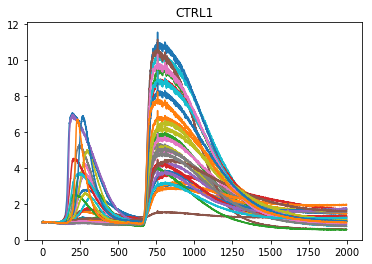

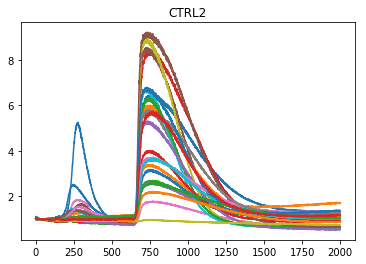

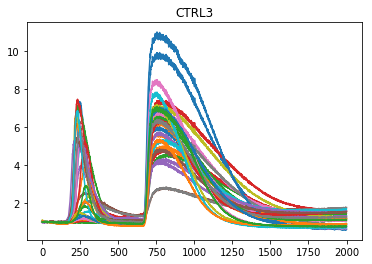

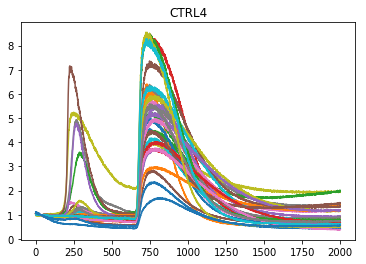

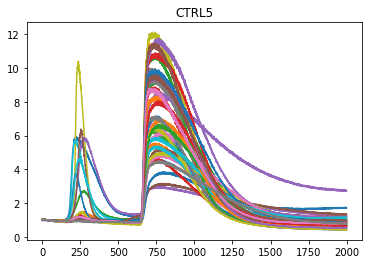

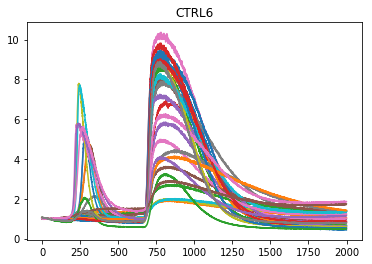

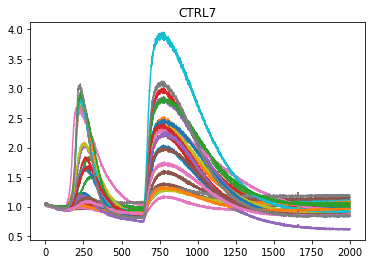

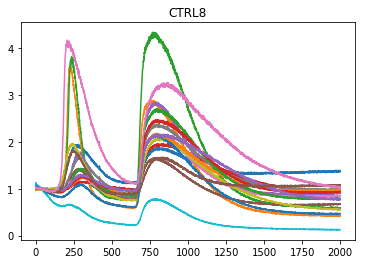

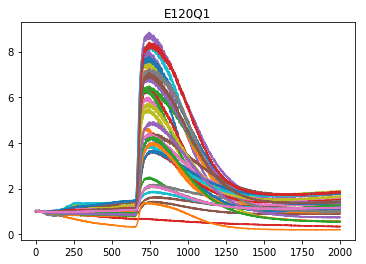

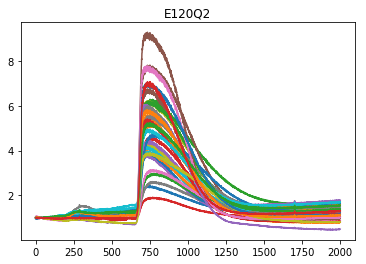

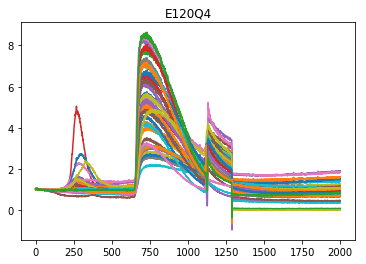

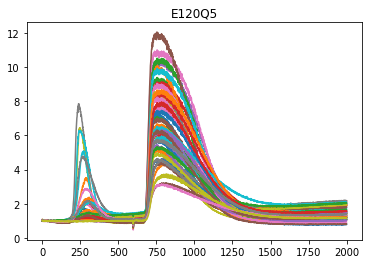

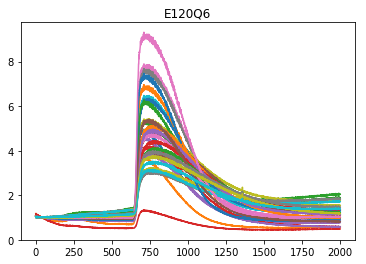

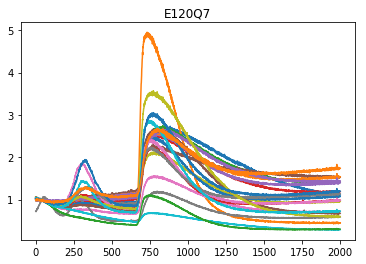

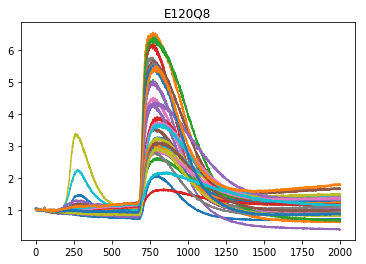

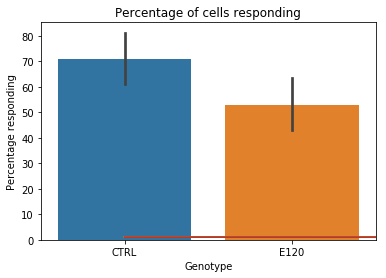

In [6]:
# call the newly created `plot_traces' function (output is suppressed)
plot_traces(df=ca_data, plot=True)

#Plot average number of responding cells per slide for each cell type
filtered_data = percentage_response(ca_data, threshold=1.1, utp_range=(40,600))


In [7]:
#step 1: Make a new empty dataframe outside the for loop
#step 2: To get desired column, [idx] --> type of a panda series
#step 3: 1st reinteration, concatenate new data frame 
#step 4: concatenate with next dataframe



def combined_data(df):
    """
    this function combines data from different 
    coverslips of the same cell type 
    into 1 data frame using regular expression
    
    ------------------------------
    arguments:
    df        - filtered data from `ca_response_rate` function
    """
    column_names = df.columns
    ctrl_data = pd.DataFrame()
    l89a_data = pd.DataFrame()

    #print(column_names)
    pattern = re.compile("CTRL.*")
    for column_name in column_names:
        if pattern.match(column_name):
            temp1 = {column_name: filtered_data[column_name]}
            ctrl_data = pd.concat([ctrl_data, pd.DataFrame(temp1)], axis=1)
        else:
            temp2 = {column_name: filtered_data[column_name]}
            l89a_data = pd.concat([l89a_data, pd.DataFrame(temp2)], axis=1)
        
    return ctrl_data, l89a_data
            

In [8]:
ctrl_data, l89a_data = combined_data(df=filtered_data)

In [9]:
def max_amp_plot(df, utp_range=(40, 6000), title='none'):
    """
    document me!
    """
    column_names = df.columns
    d = {}
    for column_name in column_names: 
        df_max = df.iloc[utp_range[0]:utp_range[1], :].max()
        df_max.plot.box(title=title) 
        
    return df_max


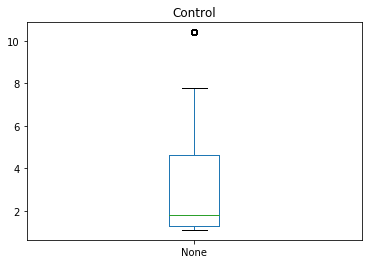

In [10]:
ctrl_max = max_amp_plot(df=ctrl_data, utp_range=(40, 480), title='Control')


#def max_amp_plot(df, col_names, utp_range=(40, 480), title):
#calc_response_rate(df=ca_data, threshold=1.2, utp_range=(40, 480), verbose=True, plot=True)

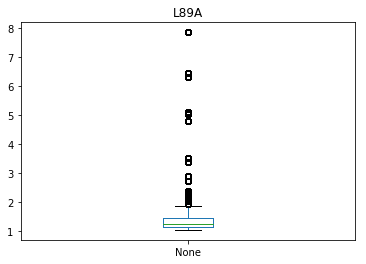

In [11]:
l89a_max = max_amp_plot(df=l89a_data, utp_range=(40, 480), title='L89A')

In [12]:
##scipy.stats.ttest_ind(a, b, axis=0, equal_var=True, nan_policy='propagate')[source]
print(stats.ttest_ind(a=ctrl_max, b=l89a_max))

Ttest_indResult(statistic=7.094521762610456, pvalue=8.905746972280601e-12)


In [13]:
#correct if the population S.D. is expected to be equal for the two groups.
def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

In [14]:
effect_size = cohen_d(x=ctrl_max, y=l89a_max)
print(effect_size)

#ctrl_max = max_amp_plot(df=ctrl_data, col_names=column_names, utp_range=(40, 480), title='Control')

0.8052906901210567


In [15]:
def make_df(cols, ind):
    """Quickly make a DataFrame"""
    time = (np.linspace(0,499.75,2000))
    data = {c: [str(c) + str(i) for i in time]
            for c in cols}
    return pd.DataFrame(data, ind)

# example DataFrame
time_column = make_df('A', range(2000))
time_column =pd.DataFrame(time_column)
print(time_column)

            A
0        A0.0
1       A0.25
2        A0.5
3       A0.75
4        A1.0
5       A1.25
6        A1.5
7       A1.75
8        A2.0
9       A2.25
10       A2.5
11      A2.75
12       A3.0
13      A3.25
14       A3.5
15      A3.75
16       A4.0
17      A4.25
18       A4.5
19      A4.75
20       A5.0
21      A5.25
22       A5.5
23      A5.75
24       A6.0
25      A6.25
26       A6.5
27      A6.75
28       A7.0
29      A7.25
...       ...
1970   A492.5
1971  A492.75
1972   A493.0
1973  A493.25
1974   A493.5
1975  A493.75
1976   A494.0
1977  A494.25
1978   A494.5
1979  A494.75
1980   A495.0
1981  A495.25
1982   A495.5
1983  A495.75
1984   A496.0
1985  A496.25
1986   A496.5
1987  A496.75
1988   A497.0
1989  A497.25
1990   A497.5
1991  A497.75
1992   A498.0
1993  A498.25
1994   A498.5
1995  A498.75
1996   A499.0
1997  A499.25
1998   A499.5
1999  A499.75

[2000 rows x 1 columns]


In [16]:
# make a list of the header row and strip up to the 4th letter. This is the location and year information
column_name = ctrl_data.columns
genotype = [str(x)[:4] for x in column_name]
coverslip=[str(x)[4:5] for x in column_name]
cell_no=[str(x)[6:] for x in column_name]
time = pd.DataFrame({'Time (s)': np.linspace(0,299.75,1200)})

d = {'Genotype': genotype, 'Coverslip': coverslip, 'Cell number': cell_no}
e = pd.DataFrame(d)
f = time_column.join(ctrl_data)
f = f.set_index('A')
#print(f)
f = f.transpose()
#print(f)
f = f.reset_index()
f = f.drop('index', axis=1)
tidy_ctrl = e.join(f)
print(tidy_ctrl)

    Genotype Coverslip Cell number      A0.0     A0.25      A0.5     A0.75  \
0       CTRL         1           1  0.970232  0.978150  0.988229  0.982648   
1       CTRL         1           2  0.989067  0.998045  1.005716  0.999409   
2       CTRL         1           3  0.983598  0.990497  0.997691  0.990247   
3       CTRL         1           4  0.970669  0.974009  0.983996  0.980929   
4       CTRL         1           5  1.006355  1.008156  1.017477  1.010433   
5       CTRL         1           6  0.973757  0.977658  0.987128  0.981860   
6       CTRL         1           7  0.996357  1.001210  1.010671  1.002292   
7       CTRL         1          10  0.988187  0.992323  1.000213  0.989850   
8       CTRL         1          11  0.975550  0.986200  0.990236  0.986828   
9       CTRL         1          13  0.979538  0.985680  0.994899  0.981952   
10      CTRL         1          14  0.998405  1.006003  1.012708  1.003956   
11      CTRL         1          17  0.990745  0.997549  1.007126

In [17]:
# make a list of the header row and strip up to the 4th letter. This is the location and year information
column_name_l89a = l89a_data.columns
genotype_a = [str(x)[:5] for x in column_name_l89a]
coverslip_a=[str(x)[5:6] for x in column_name_l89a]
cell_no_a=[str(x)[7:] for x in column_name_l89a]

g = {'Genotype': genotype_a, 'Coverslip': coverslip_a, 'Cell number': cell_no_a}
h = pd.DataFrame(g)
i = time_column.join(l89a_data)
i = i.set_index('A')
#print(f)
i = i.transpose()
#print(f)
i = i.reset_index()
i = i.drop('index', axis=1)
tidy_l89a = h.join(i)
print(tidy_l89a)


    Genotype Coverslip Cell number      A0.0     A0.25      A0.5     A0.75  \
0      E120Q         1           2  0.995710  0.981904  0.994252  0.984214   
1      E120Q         1           7  0.994787  0.990487  0.997270  0.986366   
2      E120Q         1          11  1.023975  1.014382  1.024296  1.010819   
3      E120Q         1          13  0.977389  0.977976  0.982677  0.976839   
4      E120Q         1          14  0.992286  0.992341  0.997410  0.985723   
5      E120Q         1          15  0.996749  0.993853  0.999509  0.995191   
6      E120Q         1          16  0.989701  0.986828  0.993935  0.991048   
7      E120Q         1          17  1.003738  1.001774  1.011581  1.008126   
8      E120Q         1          18  0.988827  0.986038  0.993185  0.988903   
9      E120Q         1          19  1.002331  0.999499  1.006803  0.997181   
10     E120Q         1          20  0.985219  0.986163  0.993930  0.989165   
11     E120Q         1          25  1.006713  1.002101  1.010543

In [18]:
total_data = pd.concat([tidy_ctrl, tidy_l89a], axis=0, ignore_index=True)
tidy = pd.DataFrame()
times = pd.DataFrame({'Time (s)': np.linspace(0,399.75,2000)})
for i, row in total_data.iterrows():
    #print('this is a new row')
    temp1 = total_data.iloc[i:i+1, 0:3]
    temp2 = pd.concat([temp1]*2000, ignore_index=True)
    temp3 = time.join(temp2, sort=True)
    
    temp4 = total_data.iloc[i:i+1, 3:2004]
    temp5 = temp4.T
    temp6 = temp5.reset_index()
    temp7 = temp6.rename(columns = {temp6.columns[1]: 'F/Fo'})
    temp8 = temp7.iloc[:,1]
    temp9 = temp3.join(temp8)
    tidy = pd.concat([tidy, temp9], ignore_index=True)
    print(tidy)
print(tidy)
    



      Time (s) Genotype Coverslip Cell number      F/Fo
0         0.00     CTRL         1           1  0.970232
1         0.25     CTRL         1           1  0.978150
2         0.50     CTRL         1           1  0.988229
3         0.75     CTRL         1           1  0.982648
4         1.00     CTRL         1           1  0.978944
5         1.25     CTRL         1           1  0.988820
6         1.50     CTRL         1           1  0.976444
7         1.75     CTRL         1           1  0.977446
8         2.00     CTRL         1           1  0.993823
9         2.25     CTRL         1           1  0.974022
10        2.50     CTRL         1           1  0.971459
11        2.75     CTRL         1           1  0.987349
12        3.00     CTRL         1           1  0.980740
13        3.25     CTRL         1           1  0.979779
14        3.50     CTRL         1           1  0.975068
15        3.75     CTRL         1           1  0.977419
16        4.00     CTRL         1           1  0

      Time (s) Genotype Coverslip Cell number      F/Fo
0         0.00     CTRL         1           1  0.970232
1         0.25     CTRL         1           1  0.978150
2         0.50     CTRL         1           1  0.988229
3         0.75     CTRL         1           1  0.982648
4         1.00     CTRL         1           1  0.978944
5         1.25     CTRL         1           1  0.988820
6         1.50     CTRL         1           1  0.976444
7         1.75     CTRL         1           1  0.977446
8         2.00     CTRL         1           1  0.993823
9         2.25     CTRL         1           1  0.974022
10        2.50     CTRL         1           1  0.971459
11        2.75     CTRL         1           1  0.987349
12        3.00     CTRL         1           1  0.980740
13        3.25     CTRL         1           1  0.979779
14        3.50     CTRL         1           1  0.975068
15        3.75     CTRL         1           1  0.977419
16        4.00     CTRL         1           1  0

      Time (s) Genotype Coverslip Cell number      F/Fo
0         0.00     CTRL         1           1  0.970232
1         0.25     CTRL         1           1  0.978150
2         0.50     CTRL         1           1  0.988229
3         0.75     CTRL         1           1  0.982648
4         1.00     CTRL         1           1  0.978944
5         1.25     CTRL         1           1  0.988820
6         1.50     CTRL         1           1  0.976444
7         1.75     CTRL         1           1  0.977446
8         2.00     CTRL         1           1  0.993823
9         2.25     CTRL         1           1  0.974022
10        2.50     CTRL         1           1  0.971459
11        2.75     CTRL         1           1  0.987349
12        3.00     CTRL         1           1  0.980740
13        3.25     CTRL         1           1  0.979779
14        3.50     CTRL         1           1  0.975068
15        3.75     CTRL         1           1  0.977419
16        4.00     CTRL         1           1  0

       Time (s) Genotype Coverslip Cell number      F/Fo
0          0.00     CTRL         1           1  0.970232
1          0.25     CTRL         1           1  0.978150
2          0.50     CTRL         1           1  0.988229
3          0.75     CTRL         1           1  0.982648
4          1.00     CTRL         1           1  0.978944
5          1.25     CTRL         1           1  0.988820
6          1.50     CTRL         1           1  0.976444
7          1.75     CTRL         1           1  0.977446
8          2.00     CTRL         1           1  0.993823
9          2.25     CTRL         1           1  0.974022
10         2.50     CTRL         1           1  0.971459
11         2.75     CTRL         1           1  0.987349
12         3.00     CTRL         1           1  0.980740
13         3.25     CTRL         1           1  0.979779
14         3.50     CTRL         1           1  0.975068
15         3.75     CTRL         1           1  0.977419
16         4.00     CTRL       

       Time (s) Genotype Coverslip Cell number      F/Fo
0          0.00     CTRL         1           1  0.970232
1          0.25     CTRL         1           1  0.978150
2          0.50     CTRL         1           1  0.988229
3          0.75     CTRL         1           1  0.982648
4          1.00     CTRL         1           1  0.978944
5          1.25     CTRL         1           1  0.988820
6          1.50     CTRL         1           1  0.976444
7          1.75     CTRL         1           1  0.977446
8          2.00     CTRL         1           1  0.993823
9          2.25     CTRL         1           1  0.974022
10         2.50     CTRL         1           1  0.971459
11         2.75     CTRL         1           1  0.987349
12         3.00     CTRL         1           1  0.980740
13         3.25     CTRL         1           1  0.979779
14         3.50     CTRL         1           1  0.975068
15         3.75     CTRL         1           1  0.977419
16         4.00     CTRL       

       Time (s) Genotype Coverslip Cell number      F/Fo
0          0.00     CTRL         1           1  0.970232
1          0.25     CTRL         1           1  0.978150
2          0.50     CTRL         1           1  0.988229
3          0.75     CTRL         1           1  0.982648
4          1.00     CTRL         1           1  0.978944
5          1.25     CTRL         1           1  0.988820
6          1.50     CTRL         1           1  0.976444
7          1.75     CTRL         1           1  0.977446
8          2.00     CTRL         1           1  0.993823
9          2.25     CTRL         1           1  0.974022
10         2.50     CTRL         1           1  0.971459
11         2.75     CTRL         1           1  0.987349
12         3.00     CTRL         1           1  0.980740
13         3.25     CTRL         1           1  0.979779
14         3.50     CTRL         1           1  0.975068
15         3.75     CTRL         1           1  0.977419
16         4.00     CTRL       

       Time (s) Genotype Coverslip Cell number      F/Fo
0          0.00     CTRL         1           1  0.970232
1          0.25     CTRL         1           1  0.978150
2          0.50     CTRL         1           1  0.988229
3          0.75     CTRL         1           1  0.982648
4          1.00     CTRL         1           1  0.978944
5          1.25     CTRL         1           1  0.988820
6          1.50     CTRL         1           1  0.976444
7          1.75     CTRL         1           1  0.977446
8          2.00     CTRL         1           1  0.993823
9          2.25     CTRL         1           1  0.974022
10         2.50     CTRL         1           1  0.971459
11         2.75     CTRL         1           1  0.987349
12         3.00     CTRL         1           1  0.980740
13         3.25     CTRL         1           1  0.979779
14         3.50     CTRL         1           1  0.975068
15         3.75     CTRL         1           1  0.977419
16         4.00     CTRL       

       Time (s) Genotype Coverslip Cell number      F/Fo
0          0.00     CTRL         1           1  0.970232
1          0.25     CTRL         1           1  0.978150
2          0.50     CTRL         1           1  0.988229
3          0.75     CTRL         1           1  0.982648
4          1.00     CTRL         1           1  0.978944
5          1.25     CTRL         1           1  0.988820
6          1.50     CTRL         1           1  0.976444
7          1.75     CTRL         1           1  0.977446
8          2.00     CTRL         1           1  0.993823
9          2.25     CTRL         1           1  0.974022
10         2.50     CTRL         1           1  0.971459
11         2.75     CTRL         1           1  0.987349
12         3.00     CTRL         1           1  0.980740
13         3.25     CTRL         1           1  0.979779
14         3.50     CTRL         1           1  0.975068
15         3.75     CTRL         1           1  0.977419
16         4.00     CTRL       

       Time (s) Genotype Coverslip Cell number      F/Fo
0          0.00     CTRL         1           1  0.970232
1          0.25     CTRL         1           1  0.978150
2          0.50     CTRL         1           1  0.988229
3          0.75     CTRL         1           1  0.982648
4          1.00     CTRL         1           1  0.978944
5          1.25     CTRL         1           1  0.988820
6          1.50     CTRL         1           1  0.976444
7          1.75     CTRL         1           1  0.977446
8          2.00     CTRL         1           1  0.993823
9          2.25     CTRL         1           1  0.974022
10         2.50     CTRL         1           1  0.971459
11         2.75     CTRL         1           1  0.987349
12         3.00     CTRL         1           1  0.980740
13         3.25     CTRL         1           1  0.979779
14         3.50     CTRL         1           1  0.975068
15         3.75     CTRL         1           1  0.977419
16         4.00     CTRL       

       Time (s) Genotype Coverslip Cell number      F/Fo
0          0.00     CTRL         1           1  0.970232
1          0.25     CTRL         1           1  0.978150
2          0.50     CTRL         1           1  0.988229
3          0.75     CTRL         1           1  0.982648
4          1.00     CTRL         1           1  0.978944
5          1.25     CTRL         1           1  0.988820
6          1.50     CTRL         1           1  0.976444
7          1.75     CTRL         1           1  0.977446
8          2.00     CTRL         1           1  0.993823
9          2.25     CTRL         1           1  0.974022
10         2.50     CTRL         1           1  0.971459
11         2.75     CTRL         1           1  0.987349
12         3.00     CTRL         1           1  0.980740
13         3.25     CTRL         1           1  0.979779
14         3.50     CTRL         1           1  0.975068
15         3.75     CTRL         1           1  0.977419
16         4.00     CTRL       

       Time (s) Genotype Coverslip Cell number      F/Fo
0          0.00     CTRL         1           1  0.970232
1          0.25     CTRL         1           1  0.978150
2          0.50     CTRL         1           1  0.988229
3          0.75     CTRL         1           1  0.982648
4          1.00     CTRL         1           1  0.978944
5          1.25     CTRL         1           1  0.988820
6          1.50     CTRL         1           1  0.976444
7          1.75     CTRL         1           1  0.977446
8          2.00     CTRL         1           1  0.993823
9          2.25     CTRL         1           1  0.974022
10         2.50     CTRL         1           1  0.971459
11         2.75     CTRL         1           1  0.987349
12         3.00     CTRL         1           1  0.980740
13         3.25     CTRL         1           1  0.979779
14         3.50     CTRL         1           1  0.975068
15         3.75     CTRL         1           1  0.977419
16         4.00     CTRL       

       Time (s) Genotype Coverslip Cell number      F/Fo
0          0.00     CTRL         1           1  0.970232
1          0.25     CTRL         1           1  0.978150
2          0.50     CTRL         1           1  0.988229
3          0.75     CTRL         1           1  0.982648
4          1.00     CTRL         1           1  0.978944
5          1.25     CTRL         1           1  0.988820
6          1.50     CTRL         1           1  0.976444
7          1.75     CTRL         1           1  0.977446
8          2.00     CTRL         1           1  0.993823
9          2.25     CTRL         1           1  0.974022
10         2.50     CTRL         1           1  0.971459
11         2.75     CTRL         1           1  0.987349
12         3.00     CTRL         1           1  0.980740
13         3.25     CTRL         1           1  0.979779
14         3.50     CTRL         1           1  0.975068
15         3.75     CTRL         1           1  0.977419
16         4.00     CTRL       

       Time (s) Genotype Coverslip Cell number      F/Fo
0          0.00     CTRL         1           1  0.970232
1          0.25     CTRL         1           1  0.978150
2          0.50     CTRL         1           1  0.988229
3          0.75     CTRL         1           1  0.982648
4          1.00     CTRL         1           1  0.978944
5          1.25     CTRL         1           1  0.988820
6          1.50     CTRL         1           1  0.976444
7          1.75     CTRL         1           1  0.977446
8          2.00     CTRL         1           1  0.993823
9          2.25     CTRL         1           1  0.974022
10         2.50     CTRL         1           1  0.971459
11         2.75     CTRL         1           1  0.987349
12         3.00     CTRL         1           1  0.980740
13         3.25     CTRL         1           1  0.979779
14         3.50     CTRL         1           1  0.975068
15         3.75     CTRL         1           1  0.977419
16         4.00     CTRL       

       Time (s) Genotype Coverslip Cell number      F/Fo
0          0.00     CTRL         1           1  0.970232
1          0.25     CTRL         1           1  0.978150
2          0.50     CTRL         1           1  0.988229
3          0.75     CTRL         1           1  0.982648
4          1.00     CTRL         1           1  0.978944
5          1.25     CTRL         1           1  0.988820
6          1.50     CTRL         1           1  0.976444
7          1.75     CTRL         1           1  0.977446
8          2.00     CTRL         1           1  0.993823
9          2.25     CTRL         1           1  0.974022
10         2.50     CTRL         1           1  0.971459
11         2.75     CTRL         1           1  0.987349
12         3.00     CTRL         1           1  0.980740
13         3.25     CTRL         1           1  0.979779
14         3.50     CTRL         1           1  0.975068
15         3.75     CTRL         1           1  0.977419
16         4.00     CTRL       

       Time (s) Genotype Coverslip Cell number      F/Fo
0          0.00     CTRL         1           1  0.970232
1          0.25     CTRL         1           1  0.978150
2          0.50     CTRL         1           1  0.988229
3          0.75     CTRL         1           1  0.982648
4          1.00     CTRL         1           1  0.978944
5          1.25     CTRL         1           1  0.988820
6          1.50     CTRL         1           1  0.976444
7          1.75     CTRL         1           1  0.977446
8          2.00     CTRL         1           1  0.993823
9          2.25     CTRL         1           1  0.974022
10         2.50     CTRL         1           1  0.971459
11         2.75     CTRL         1           1  0.987349
12         3.00     CTRL         1           1  0.980740
13         3.25     CTRL         1           1  0.979779
14         3.50     CTRL         1           1  0.975068
15         3.75     CTRL         1           1  0.977419
16         4.00     CTRL       

       Time (s) Genotype Coverslip Cell number      F/Fo
0          0.00     CTRL         1           1  0.970232
1          0.25     CTRL         1           1  0.978150
2          0.50     CTRL         1           1  0.988229
3          0.75     CTRL         1           1  0.982648
4          1.00     CTRL         1           1  0.978944
5          1.25     CTRL         1           1  0.988820
6          1.50     CTRL         1           1  0.976444
7          1.75     CTRL         1           1  0.977446
8          2.00     CTRL         1           1  0.993823
9          2.25     CTRL         1           1  0.974022
10         2.50     CTRL         1           1  0.971459
11         2.75     CTRL         1           1  0.987349
12         3.00     CTRL         1           1  0.980740
13         3.25     CTRL         1           1  0.979779
14         3.50     CTRL         1           1  0.975068
15         3.75     CTRL         1           1  0.977419
16         4.00     CTRL       

       Time (s) Genotype Coverslip Cell number      F/Fo
0          0.00     CTRL         1           1  0.970232
1          0.25     CTRL         1           1  0.978150
2          0.50     CTRL         1           1  0.988229
3          0.75     CTRL         1           1  0.982648
4          1.00     CTRL         1           1  0.978944
5          1.25     CTRL         1           1  0.988820
6          1.50     CTRL         1           1  0.976444
7          1.75     CTRL         1           1  0.977446
8          2.00     CTRL         1           1  0.993823
9          2.25     CTRL         1           1  0.974022
10         2.50     CTRL         1           1  0.971459
11         2.75     CTRL         1           1  0.987349
12         3.00     CTRL         1           1  0.980740
13         3.25     CTRL         1           1  0.979779
14         3.50     CTRL         1           1  0.975068
15         3.75     CTRL         1           1  0.977419
16         4.00     CTRL       

       Time (s) Genotype Coverslip Cell number      F/Fo
0          0.00     CTRL         1           1  0.970232
1          0.25     CTRL         1           1  0.978150
2          0.50     CTRL         1           1  0.988229
3          0.75     CTRL         1           1  0.982648
4          1.00     CTRL         1           1  0.978944
5          1.25     CTRL         1           1  0.988820
6          1.50     CTRL         1           1  0.976444
7          1.75     CTRL         1           1  0.977446
8          2.00     CTRL         1           1  0.993823
9          2.25     CTRL         1           1  0.974022
10         2.50     CTRL         1           1  0.971459
11         2.75     CTRL         1           1  0.987349
12         3.00     CTRL         1           1  0.980740
13         3.25     CTRL         1           1  0.979779
14         3.50     CTRL         1           1  0.975068
15         3.75     CTRL         1           1  0.977419
16         4.00     CTRL       

       Time (s) Genotype Coverslip Cell number      F/Fo
0          0.00     CTRL         1           1  0.970232
1          0.25     CTRL         1           1  0.978150
2          0.50     CTRL         1           1  0.988229
3          0.75     CTRL         1           1  0.982648
4          1.00     CTRL         1           1  0.978944
5          1.25     CTRL         1           1  0.988820
6          1.50     CTRL         1           1  0.976444
7          1.75     CTRL         1           1  0.977446
8          2.00     CTRL         1           1  0.993823
9          2.25     CTRL         1           1  0.974022
10         2.50     CTRL         1           1  0.971459
11         2.75     CTRL         1           1  0.987349
12         3.00     CTRL         1           1  0.980740
13         3.25     CTRL         1           1  0.979779
14         3.50     CTRL         1           1  0.975068
15         3.75     CTRL         1           1  0.977419
16         4.00     CTRL       

       Time (s) Genotype Coverslip Cell number      F/Fo
0          0.00     CTRL         1           1  0.970232
1          0.25     CTRL         1           1  0.978150
2          0.50     CTRL         1           1  0.988229
3          0.75     CTRL         1           1  0.982648
4          1.00     CTRL         1           1  0.978944
5          1.25     CTRL         1           1  0.988820
6          1.50     CTRL         1           1  0.976444
7          1.75     CTRL         1           1  0.977446
8          2.00     CTRL         1           1  0.993823
9          2.25     CTRL         1           1  0.974022
10         2.50     CTRL         1           1  0.971459
11         2.75     CTRL         1           1  0.987349
12         3.00     CTRL         1           1  0.980740
13         3.25     CTRL         1           1  0.979779
14         3.50     CTRL         1           1  0.975068
15         3.75     CTRL         1           1  0.977419
16         4.00     CTRL       

       Time (s) Genotype Coverslip Cell number      F/Fo
0          0.00     CTRL         1           1  0.970232
1          0.25     CTRL         1           1  0.978150
2          0.50     CTRL         1           1  0.988229
3          0.75     CTRL         1           1  0.982648
4          1.00     CTRL         1           1  0.978944
5          1.25     CTRL         1           1  0.988820
6          1.50     CTRL         1           1  0.976444
7          1.75     CTRL         1           1  0.977446
8          2.00     CTRL         1           1  0.993823
9          2.25     CTRL         1           1  0.974022
10         2.50     CTRL         1           1  0.971459
11         2.75     CTRL         1           1  0.987349
12         3.00     CTRL         1           1  0.980740
13         3.25     CTRL         1           1  0.979779
14         3.50     CTRL         1           1  0.975068
15         3.75     CTRL         1           1  0.977419
16         4.00     CTRL       

       Time (s) Genotype Coverslip Cell number      F/Fo
0          0.00     CTRL         1           1  0.970232
1          0.25     CTRL         1           1  0.978150
2          0.50     CTRL         1           1  0.988229
3          0.75     CTRL         1           1  0.982648
4          1.00     CTRL         1           1  0.978944
5          1.25     CTRL         1           1  0.988820
6          1.50     CTRL         1           1  0.976444
7          1.75     CTRL         1           1  0.977446
8          2.00     CTRL         1           1  0.993823
9          2.25     CTRL         1           1  0.974022
10         2.50     CTRL         1           1  0.971459
11         2.75     CTRL         1           1  0.987349
12         3.00     CTRL         1           1  0.980740
13         3.25     CTRL         1           1  0.979779
14         3.50     CTRL         1           1  0.975068
15         3.75     CTRL         1           1  0.977419
16         4.00     CTRL       

       Time (s) Genotype Coverslip Cell number      F/Fo
0          0.00     CTRL         1           1  0.970232
1          0.25     CTRL         1           1  0.978150
2          0.50     CTRL         1           1  0.988229
3          0.75     CTRL         1           1  0.982648
4          1.00     CTRL         1           1  0.978944
5          1.25     CTRL         1           1  0.988820
6          1.50     CTRL         1           1  0.976444
7          1.75     CTRL         1           1  0.977446
8          2.00     CTRL         1           1  0.993823
9          2.25     CTRL         1           1  0.974022
10         2.50     CTRL         1           1  0.971459
11         2.75     CTRL         1           1  0.987349
12         3.00     CTRL         1           1  0.980740
13         3.25     CTRL         1           1  0.979779
14         3.50     CTRL         1           1  0.975068
15         3.75     CTRL         1           1  0.977419
16         4.00     CTRL       

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1           1  0.970232
1           0.25     CTRL         1           1  0.978150
2           0.50     CTRL         1           1  0.988229
3           0.75     CTRL         1           1  0.982648
4           1.00     CTRL         1           1  0.978944
5           1.25     CTRL         1           1  0.988820
6           1.50     CTRL         1           1  0.976444
7           1.75     CTRL         1           1  0.977446
8           2.00     CTRL         1           1  0.993823
9           2.25     CTRL         1           1  0.974022
10          2.50     CTRL         1           1  0.971459
11          2.75     CTRL         1           1  0.987349
12          3.00     CTRL         1           1  0.980740
13          3.25     CTRL         1           1  0.979779
14          3.50     CTRL         1           1  0.975068
15          3.75     CTRL         1           1  0.977419
16          4.

In [19]:
tidy.head()

,Time (s),Genotype,Coverslip,Cell number,F/Fo
0,0.00,CTRL,1,1,0.970232
1,0.25,CTRL,1,1,0.978150
2,0.50,CTRL,1,1,0.988229
3,0.75,CTRL,1,1,0.982648
4,1.00,CTRL,1,1,0.978944


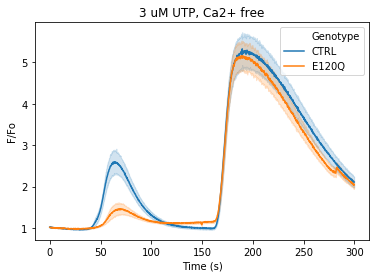

In [21]:
ax = sns.lineplot(x="Time (s)", y="F/Fo", hue="Genotype", ci=95, data=tidy).set_title('3 uM UTP, Ca2+ free')


In [23]:
writer = pd.ExcelWriter('CTRL_E120Q.xlsx', engine='xlsxwriter')
tidy.to_excel(writer, sheet_name='Sheet1')
writer.save()